In [1]:
import requests
from PIL import Image
from io import BytesIO

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch
torch.manual_seed(1234)

import numpy as np
import matplotlib.pyplot as plt

/hpc2hdd/home/cguo847/.conda/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cuda", trust_remote_code=True).eval()

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [00:35<00:00,  3.60s/it]


In [3]:
def perform_segmentation(response):
    def extract_bbox_coordinates(text):
        pattern = r"\((\d+),(\d+)\),\((\d+),(\d+)\)"
        matches = re.findall(pattern, text)
        if matches:
            bboxes = [tuple(map(int, match)) for match in matches]
            return bboxes
        else:
            print("No bounding box coordinates found in the text.")
            return None

    def extract_and_display_image(query_output):
        image_url_match = re.search(r'<img>(.*?)</img>', query_output)
        if image_url_match:
            image_url = image_url_match.group(1)
            if image_url.startswith('http://') or image_url.startswith('https://'):
                try:
                    query = requests.get(image_url)
                    if query.status_code == 200:
                        original_image = Image.open(BytesIO(query.content))
                        original_image.show()
                        return original_image
                    else:
                        print("Failed to load the image from the provided URL.")
                        return None
                except Exception as e:
                    print(f"An error occurred while downloading the image: {e}")
                    return None
            else:
                try:
                    original_image = Image.open(image_url)
                    original_image.show()
                    return original_image
                except Exception as e:
                    print(f"An error occurred while loading the image: {e}")
                    return None
        else:
            print("No image URL found in the query output.")
            return None

    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

    # Extract bounding box coordinates from the response
    input_boxes = extract_bbox_coordinates(response)
    if input_boxes is None:
        return None

    # Load and display the image
    original_image = extract_and_display_image(query)
    if original_image is None:
        return None

    image_array = np.array(original_image)

    # Set up the segmentation model
    sam_checkpoint = "./models/sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = "cuda"  # or "cpu"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)

    # Convert bounding box coordinates to absolute values
    image_width, image_height = original_image.size
    absolute_boxes = []
    for box in input_boxes:
        x1, y1, x2, y2 = box
        absolute_x1 = int(x1 / 1000 * image_width)
        absolute_y1 = int(y1 / 1000 * image_height)
        absolute_x2 = int(x2 / 1000 * image_width)
        absolute_y2 = int(y2 / 1000 * image_height)
        absolute_boxes.append([absolute_x1, absolute_y1, absolute_x2, absolute_y2])
    absolute_boxes = np.array(absolute_boxes)

    # Set the image in the predictor
    predictor.set_image(image_array)

    # Perform segmentation for each box
    plt.figure(figsize=(10, 10))
    plt.imshow(image_array)
    all_masks = []
    for box in absolute_boxes:
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=box[None, :],
            multimask_output=False,
        )
        show_mask(masks[0], plt.gca())
        show_box(box, plt.gca())
        all_masks.append(masks[0])
    plt.axis('off')
    plt.show()

    return all_masks

In [4]:
import re
from segment_anything import sam_model_registry, SamPredictor

这张图片展示了一架商用飞机在夜空中飞行，距离桥面很近，可能正在降落。飞机的前部有四个灯亮着，其中两个在机头上，两个在机翼下方。图片的地面显示有一条沿伸至远方的白线，可能是跑道或标志线。在图片的右侧，可以看到一个月亮和飞机一起照亮了暗蓝色的天空。
<ref>图片中飞机</ref><box>(343,119),(714,261)</box>


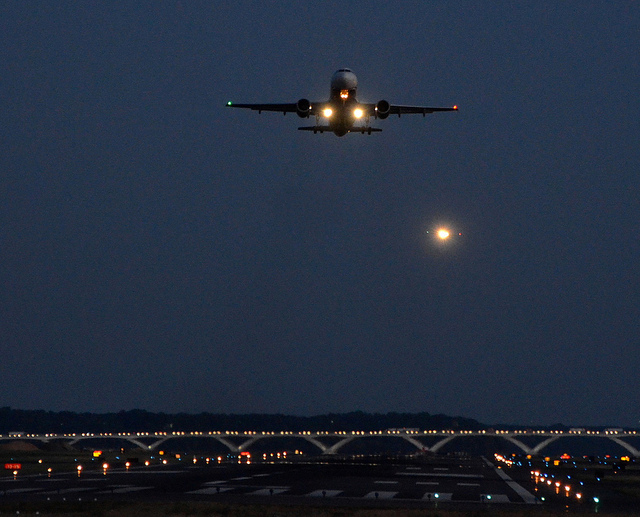

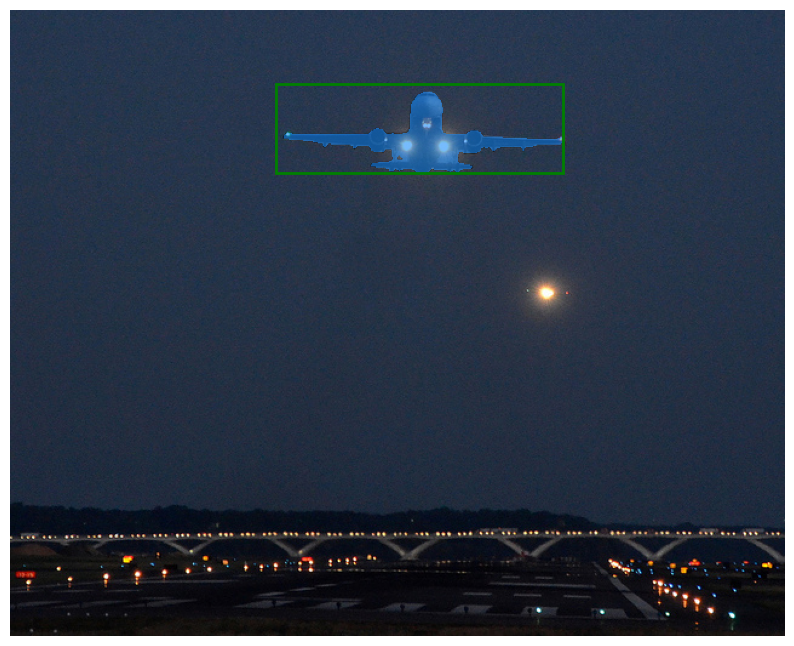

Segmentation completed successfully.


In [5]:
query = tokenizer.from_list_format([
        {'image': '/hpc2hdd/home/cguo847/train2017/000000174712.jpg'},  # Either a local path or a URL
        {'text': '这是什么?'},
    ])
response, history = model.chat(tokenizer, query=query, history=None)
print(response)

# Second round of dialogue
response, history = model.chat(tokenizer, '框出图片中飞机的位置', history=history)
print(response)

segmentation_result = perform_segmentation(response)
if segmentation_result is not None:
    print("Segmentation completed successfully.")
else:
    print("Segmentation failed.")